# Universal Pleasantness

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from copy import copy
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import pathlib
import seaborn as sns
from tqdm.auto import tqdm
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
import univple as up

/opt/mambaforge/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.11, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/opt/mambaforge/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Load the data and show the ranking for each odorant

In [3]:
data = {}
data['raw'], odorants = up.load_data()
data['ranked'], odorants = up.load_data(by='ranks')
groups, group_ids = up.get_groups(data['raw'])
#data['raw'].head()  # First 5 rows

In [4]:
data['raw'].index.unique(level='Group')

Index(['American', 'Chachi', 'Imbabura Quichua', 'Mah Meri', 'Maniq',
       'Mexican', 'Semaq Beri', 'Semelai', 'Seri', 'Thai'],
      dtype='object', name='Group')

## Figure 1: N/A (Created externally)

## Figure 2: Raw Data and Summary

In [5]:
# Rank by mean valence
odorants_by_valence = data['raw'].mean().sort_values().index

# Arrange data with mean in the first row
z = data['raw'][odorants_by_valence[::-1]]
mean = z.mean()
mean.name = 'Mean'
mean = mean.to_frame()
mean.name = 'mean'
n_mean = 10
z = pd.concat([mean.T]*n_mean + [z])
group_ranges = {'Mean': np.arange(n_mean)}
for group in groups:
    group_ranges[group] = data['raw'].reset_index().query(f'Group=="{group}"').index.values+n_mean

### Inline figure

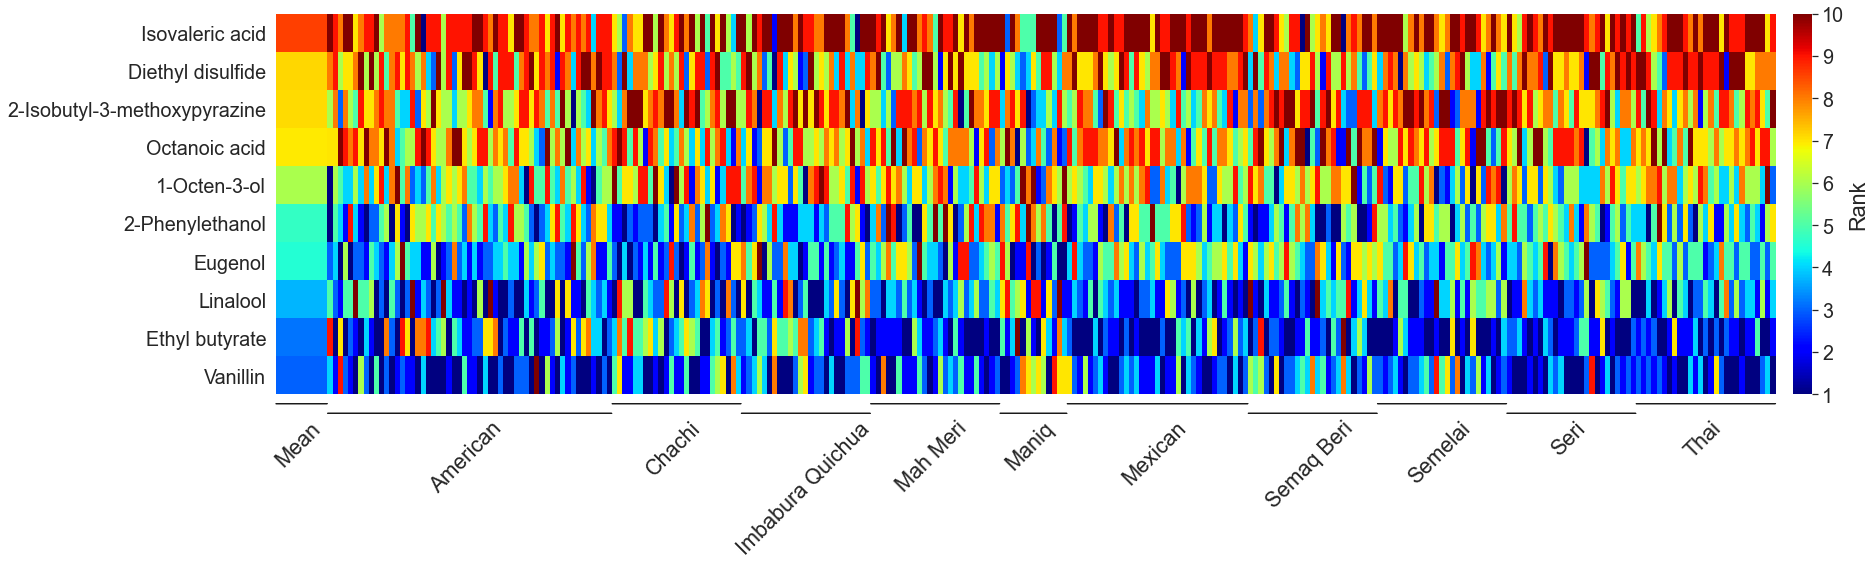

In [6]:
sns.set(font_scale=1.8)
plt.figure(figsize=(32, 7))
ax = sns.heatmap(z.T, xticklabels=[], cmap='jet', cbar_kws={'pad': 0.01, 'label': 'Rank', 'ticks':range(11)})
ax.set_xlabel('')
ax.set_ylabel('')
for i, (group, range_) in enumerate(group_ranges.items()):
    ax.text(range_.mean()-0.1, 10.6, group, ha='center', va='top', rotation=45)
    #line = lines.Line2D(x, y, lw=5., color='r', alpha=0.4)
    ax.arrow(range_.min(), 10.25+0.25*(i%2), range_.max() + 1 - range_.min(), 0, clip_on=False, color='k', length_includes_head=True)
plt.savefig('Figure 2-inline.pdf', bbox_inches="tight", format='pdf')
plt.savefig('Figure 2-inline.png', bbox_inches="tight", dpi=600, format='png')

In [7]:
#from scipy.cluster import hierarchy
#z_= z.copy()
#z_.index = z.index.map(lambda x: x[0] if len(x)==2 else x)
#for group in z_.index.unique():
#    ordering = hierarchy.leaves_list(hierarchy.linkage(z_.loc[group].values, "centroid"))
#    z_.loc[group] = z_.loc[group].values[ordering]

Figure 2: Summary of pleasantness rankings across individuals and cultures.  Between n=16 and n=55 individuals from each culture ranked each of 10 odorants in order from most (1, blue) to least (10, red) pleasant.  Each color patch represents the integer ranking that one individual (from the culture indicated at the bottom) to one odorant (indicated on the left).  The broad column on the far left represents the average ranking for each odorant across all individuals shown here.

#### Full-page figure

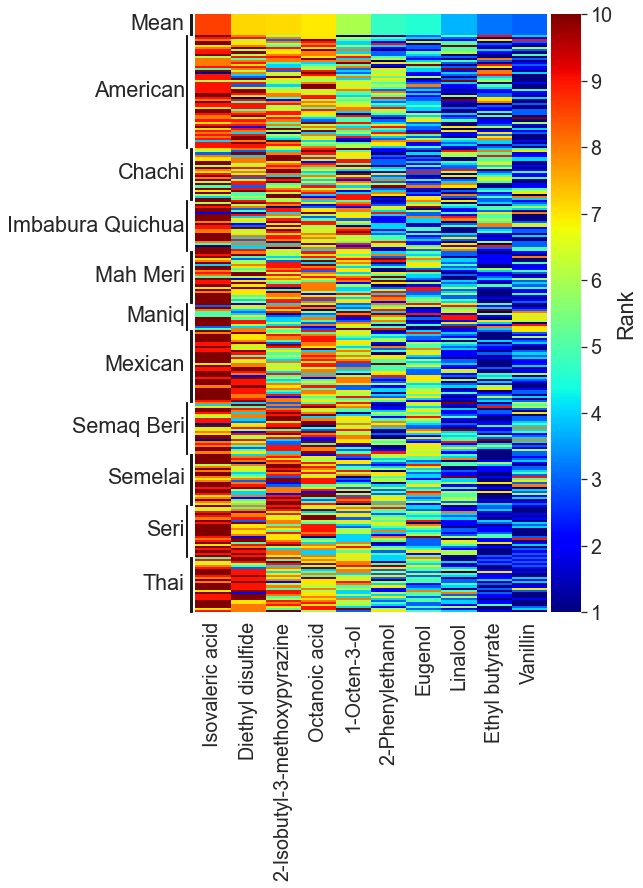

In [8]:
plt.figure(figsize=(7.5, 11))
ax = sns.heatmap(z, yticklabels=[], cmap='jet', cbar_kws={'pad': 0.01, 'label': 'Rank', 'ticks':range(11)})
ax.set_xlabel('')
ax.set_ylabel('')
for i, (group, range_) in enumerate(group_ranges.items()):
    ax.text(-0.3, range_.mean()-0.1, group, va='center', ha='right', rotation=0)
    #line = lines.Line2D(x, y, lw=5., color='r', alpha=0.4)
    ax.arrow(-0.125 - 0.125*(i%2), range_.min(), 0, range_.max() + 1 - range_.min(), clip_on=False, color='k', length_includes_head=True, head_length=0, head_width=0, width=0.05)
plt.savefig('Figure 2-fullpage.pdf', bbox_inches="tight", format='pdf')
plt.savefig('Figure 2-fullpage.png', bbox_inches="tight", dpi=600, format='png')

In [9]:
# Pearson correlation (across grouos) of within-group average ranks
z = data['raw'].groupby('Group').mean().T.corr(method='pearson')
pd.Series(z.values[np.tril_indices_from(z, -1)]).describe()

count    45.000000
mean      0.820563
std       0.180241
min       0.302655
25%       0.807088
50%       0.890036
75%       0.932126
max       0.987800
dtype: float64

### Fig. S1: Comparison of highest-ranked and lowest-ranked odorants in each culture

In [10]:
groups

['American',
 'Chachi',
 'Imbabura Quichua',
 'Mah Meri',
 'Maniq',
 'Mexican',
 'Semaq Beri',
 'Semelai',
 'Seri',
 'Thai']

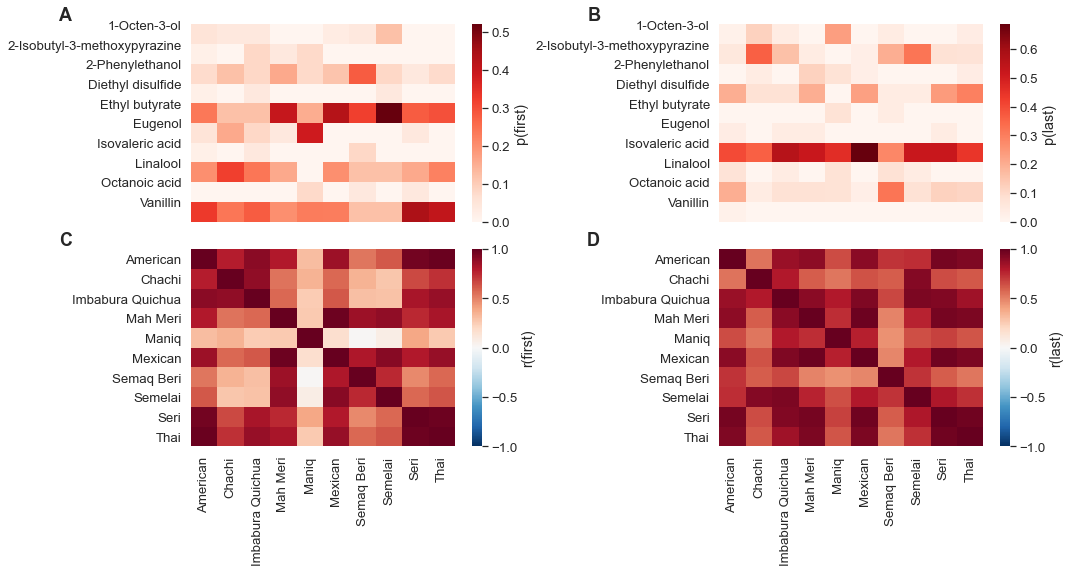

In [11]:
sns.set(font_scale=1.2)
up.fig_highest_lowest(data['ranked'], groups, odorants)
plt.savefig('Figure S1.pdf', bbox_inches="tight", format='pdf')
plt.savefig('Figure S1.png', bbox_inches="tight", dpi=600, format='png')

Figure S1: Pleasantness rankings are correlated for both the most pleasant and most unpleasant odorants.  (A) Fraction of individuals within each culture that ranked the given odorant as the most pleasant of the 10.  (B) Same as A, but for the least pleasant odorant.  (C) Correlation matrix computed from panel A; this shows correlation between cultures in the number of individuals that rated each odorant as the most pleasant.  (D) Same as C but showing a correlation matrix computed from B, for the least pleasant odorants.

## Figure 3: Effect size for each of the major factors

In [12]:
### Fit ANOVA model for current dataset and for counterfactual datasets under different hypotheses:
# - OWC: Within-culture agreement is the same, but across-culture agreement is random. Create a unique ranking shuffle for each group and apply each group's shuffle identically to the members of that group
# - I: Culture is not a predictive label.  Shuffle individuals between cultures.
eta2_mean, eta2_sd = up.get_eta2(data['raw'])

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

#### Inline figure

In [13]:
eta2_mean

Shuffle Type,raw,odors-within-culture,individuals
Source,,,
Odorant,0.407599,0.048493,0.407599
Culture x Odorant,0.055582,0.414688,0.019065
Individual,0.536819,0.536819,0.573336


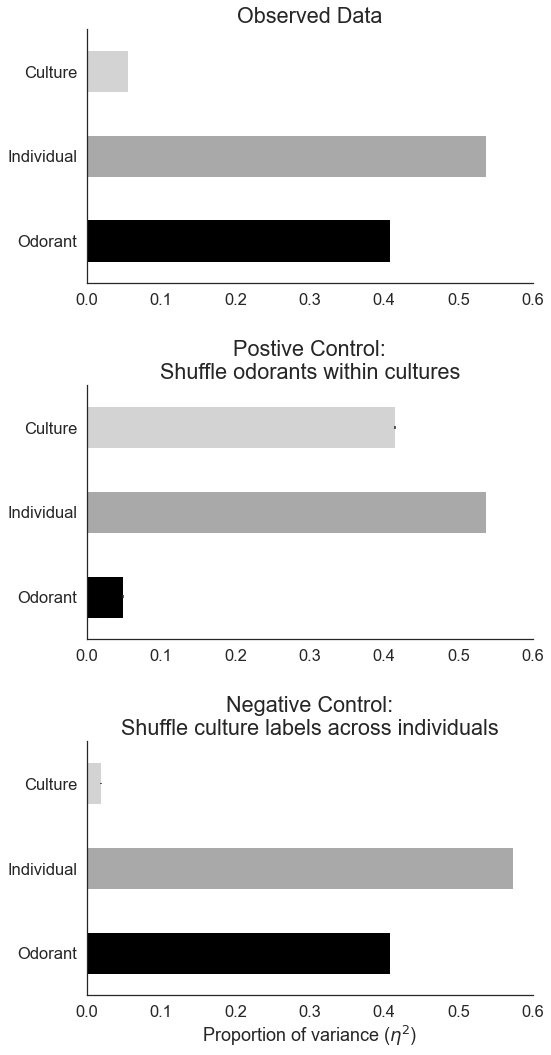

In [55]:
# Effect size for each major factor
fig, axes = plt.subplots(3, 1, figsize=(8, 15))
sns.set_style('white')
for i, kind in enumerate(['raw', 'odors-within-culture', 'individuals']):
    ax = axes.flat[i]
    up.fig_eta2(eta2_mean, eta2_sd, kind=kind, colors=['lightgray', 'darkgray', 'black'],
                direction='h', ax=ax)
    ax.set_xlim(0, 0.6)
    if i<2:
        ax.set_xlabel('')
sns.despine()
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.savefig('Figure 3-inline.pdf', bbox_inches="tight", format='pdf')
plt.savefig('Figure 3-inline.png', bbox_inches="tight", dpi=600, format='png')

Figure 3: Effect size $\eta^2$ from a two-way ANOVA for each of three factors that could potentially explain each individual's pleasantness rankings: Individual preferences (orange), Culture membership (purple), and Odor identity (green).  Data used were the ranks given for each odorant and individual.  Total effect $\eta^2$ sums to 1, and the individual factor was taken to be the total minus the effects due to odor and culture.

#### Full-page figure

In [24]:
# Effect size for each major factor

#sns.set_style('whitegrid')
#up.fig_eta2(eta2_mean, eta2_sd, simplify=True, colors=['lightgray', 'darkgray', 'black'], direction='v')
#plt.savefig('Figure 3-fullpage.pdf', bbox_inches="tight", format='pdf')
#plt.savefig('Figure 3-fullpage.png', bbox_inches="tight", dpi=600, format='png')

### Figure S2: Controls for Figure 3

In [25]:
#sns.set(font_scale=2)
#sns.set_style('whitegrid')
#up.fig_eta2(eta2_mean, eta2_sd)
#plt.savefig('Figure S2.pdf', bbox_inches="tight", format='pdf')
#plt.savefig('Figure S2.png', bbox_inches="tight", dpi=600, format='png')

Figure S2: Similar to Figure 3, but showing a positive and negative control to demonstrate that alternative scenarios would have been detected using this design.  The bottom set of bars correspond to the actual data.  The middle bars correspond to a a culture-specific shuffling of odorant labels applied to each individual (positive control).  The top bars correspond to a shuffling of culture labels across individuals (negative control).

In [26]:
# Same as above as a table
#eta2_mean.round(3)

### Figure 4: Cultures for Individuals and Model vs Individuals

In [27]:
# Compute the Kendall-Tau correlation among the various sets of rankings
model_predictions = up.get_model_predictions(odorants)
taus, ps = up.compute_kendall_taus(data['raw'], data['raw'], model=model_predictions)

  0%|          | 0/280 [00:00<?, ?it/s]

In [28]:
# Kendall-Tau correlation between individuals within and across groups
z = taus.drop('Model').groupby('Group').mean().groupby('Group', axis=1).mean().values
within = np.diag(z)
across = z[np.tril_indices_from(z, -1)]
summary = pd.Series(within, name='within').describe().to_frame().join(pd.Series(across, name='across').describe())
summary

,within,across
count,10.000000,45.000000
mean,0.317846,0.275302
std,0.139049,0.113194
min,0.043875,0.047385
25%,0.231630,0.238256
50%,0.329593,0.288330
75%,0.431333,0.353803
max,0.485341,0.480823


#### Inline figure

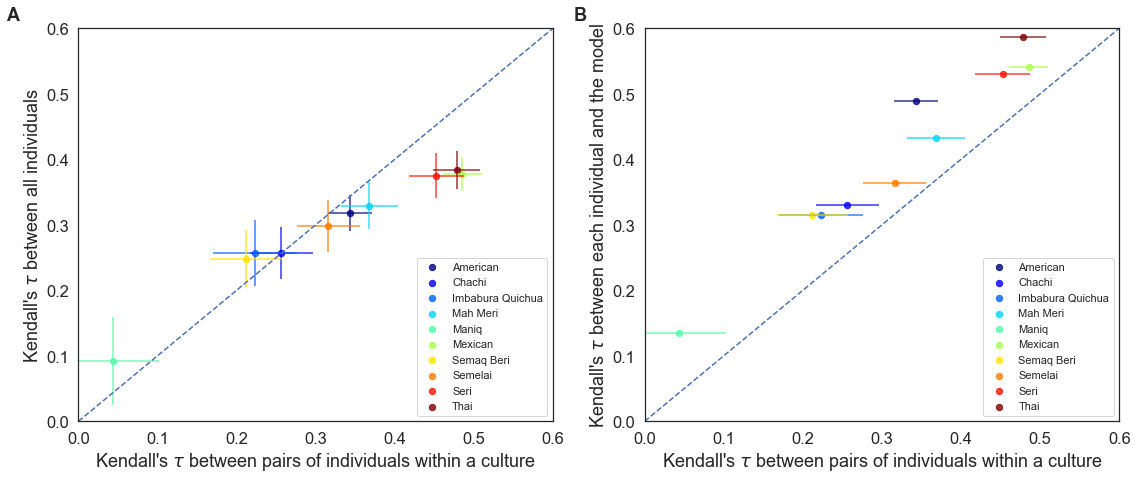

In [40]:
up.fig_kendall_tau(taus, groups, direction='h')
plt.savefig('Figure 4-inline.pdf', bbox_inches="tight", format='pdf')
plt.savefig('Figure 4-inline.png', bbox_inches="tight", dpi=600, format='png')

Figure 4: A universal model for odor pleasantness performs as well as a culture-specific one.  (A) The correlation of odor pleasantness rankings (Kendall's $\tau$) between each individual and other individuals from their culture (x-axis) is similar to the correlation between each individual and the entire population studied here.  (B) Rankings predicted by a computational model trained on perceived pleasantness ratings for out-of-sample odorants are more correlated with individual rankings for the odorants used here than are other individuals from the same culture.

#### Full-page figure

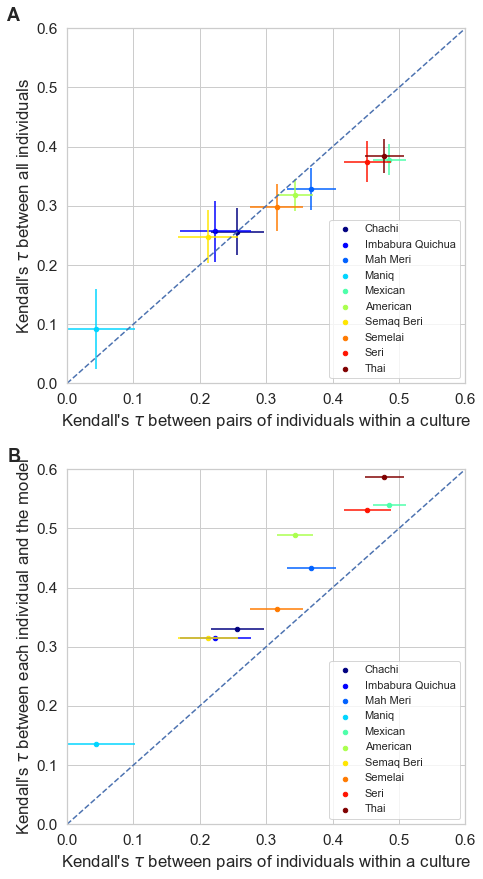

In [18]:
up.fig_kendall_tau(taus, groups, direction='v')
plt.savefig('Figure 4-fullpage.pdf', bbox_inches="tight", format='pdf')
plt.savefig('Figure 4-fullpage.png', bbox_inches="tight", dpi=600, format='png')

### Fig. S3 and S4: See bayesian-analysis.ipynb for Bayesian analysis and figures.

### Fig. S5: Intensity Controls

In [41]:
data['intensity'] = up.load_intensity_data(odorants, by='odor')
#data['intensity']

In [42]:
# Pleasantness vs Intensity
taus_pi, ps_pi = up.compute_kendall_taus(data['raw'], data['intensity'])

  0%|          | 0/280 [00:00<?, ?it/s]

In [43]:
# Pleasantness vs Pleasantness
taus_pp, ps_pp = up.compute_kendall_taus(data['raw'], data['raw'])

  0%|          | 0/280 [00:00<?, ?it/s]

In [44]:
# Intensity vs Intensity
taus_ii, ps_ii = up.compute_kendall_taus(data['intensity'], data['intensity'])

  0%|          | 0/125 [00:00<?, ?it/s]

Pleasantness vs Intensity:
	Tau Same Culture: -0.024 +/- 0.022
	Tau Different Culture: -0.025 +/- 0.04
Intensity vs Intensity:
	Tau Same Culture: 0.24 +/- 0.024
	Tau Different Culture: 0.17 +/- 0.044
Pleasantness vs Pleasantness
	Tau Same Culture: 0.32 +/- 0.14
	Tau Different Culture: 0.28 +/- 0.11


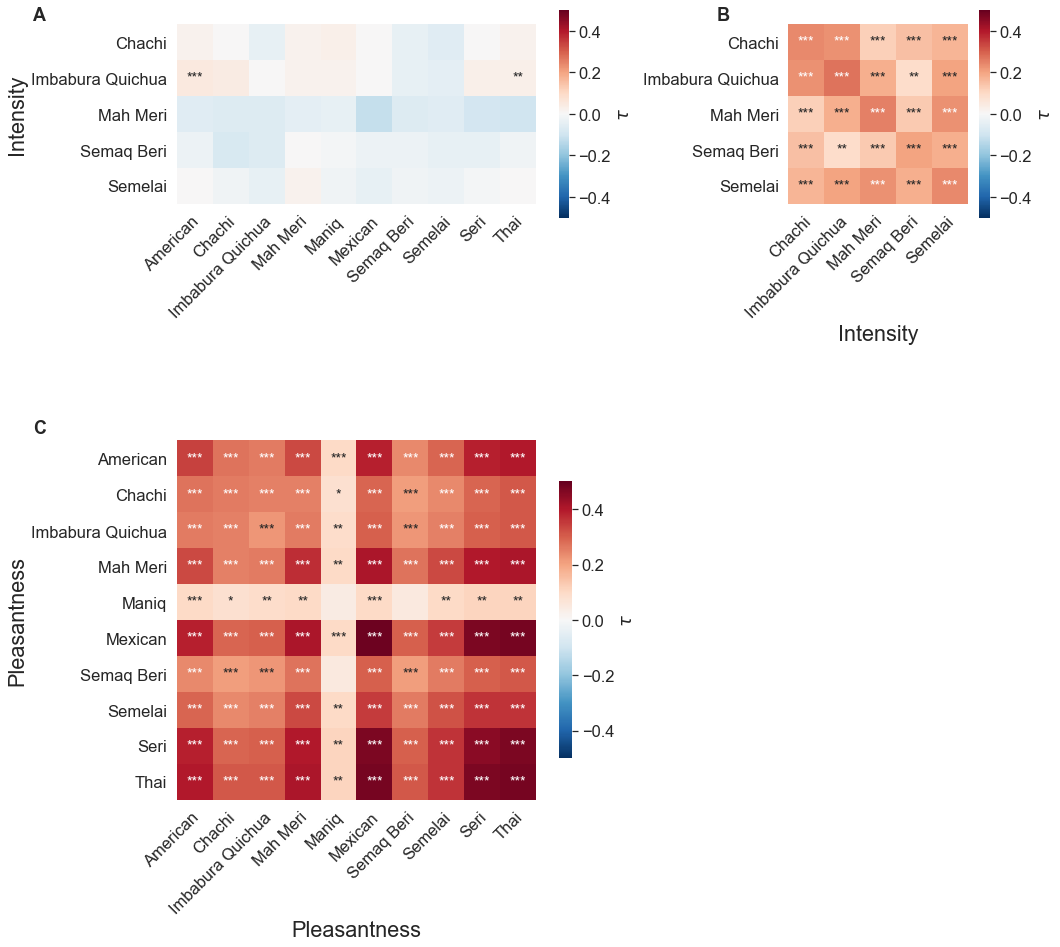

In [47]:
sns.set(font_scale=1.5)
up.fig_intensity_control(taus_pi, taus_pp, taus_ii, ps_pi, ps_pp, ps_ii)
plt.savefig('Figure S5.pdf', bbox_inches="tight", format='pdf')
plt.savefig('Figure S5.png', bbox_inches="tight", dpi=600, format='png')

Figure S3: The correlations across cultures in pleasantness rankings are not explained by perceived intensity.  (A) Rank correlations (Kendall's $\tau$) between individuals of the ranked pleasantness of the 10 odorants (x-axis) and the ranked intensity of the 10 odorants (y-axis) were computed, and the mean $\tau$ reported for such pairs of individuals within and across cultures. Such correlations were consistenly near zero and not significant. Note that intensity data was collected in only some cultures, but from the same set of individuals as the pleasantness data. (B) The correlation between individuals for intensity alone was significantly positive, suggesting a "universal intensity" factor that is indepenent of pleasantness. (C) The correlation between individuals for pleasantness alone is positive and signficiantly greater than that observed for intensity.  In all panels, comparisons between and individual and themselves were excluded. All rank correlations are annotated with statistical significance according to a binomial test, comparing the fraction of pairs of individuals that had $\tau>0$ against the null hypothesis of fraction 1/2.  \*: p<0.01; \*\*: p<1e-4; \*\*\*: p<1e-10.

## Fig. S6: Maniq ranking controls

In [48]:
# Get the names of the animals
animal_key = pd.read_csv('data/Pleasantness_Maniq Control Task.txt', sep='\t', index_col=0).iloc[-8:, :]['best']
animal_key = animal_key.str.title()
animal_key  # Key-value pairs of Maniq name and English name for the animal

basi_      Dusky Leaf Monkey
kayo_           Flying Lemur
wac                 Squirrel
ta___                  Tiger
kapiy    Soft-Shelled Turtle
t_t__               Bird Sp.
y_k_p                  Snake
_a__s               Mosquito
Name: best, dtype: object

In [49]:
animal_key['t_t__'] = 'Bird (drongo, Dicrurus sp.)'

In [50]:
# Get the ranks for the animals that were provided by the participants
animal_ranks = pd.read_csv('data/Pleasantness_Maniq Control Task.txt', sep='\t', index_col=0).iloc[:10, :8]
animal_ranks = animal_ranks.rename(columns={x: x.split(': ')[1] for x in animal_ranks.columns if 'Unnamed' in x})
animal_ranks

,best,2,3,4,5,6,7,worst
Participant 14,basi_,wac,ta___,kayo_,_a__s,y_k_p,kapiy,t_t__
Participant 15,basi_,kayo_,y_k_p,wac,ta___,kapiy,t_t__,_a__s
Participant 2,basi_,kayo_,t_t__,wac,kapiy,ta___,y_k_p,_a__s
Participant 7,basi_,kayo_,wac,kapiy,ta___,t_t__,_a__s,y_k_p
Participant 5,kapiy,basi_,ta___,kayo_,t_t__,wac,_a__s,y_k_p
Participant 12,basi_,kapiy,wac,kayo_,t_t__,y_k_p,ta___,_a__s
Participant 6,basi_,ta___,kapiy,wac,t_t__,kayo_,y_k_p,_a__s
Participant 11,wac,basi_,t_t__,kapiy,kayo_,y_k_p,_a__s,ta___
Participant 3,basi_,kapiy,kayo_,wac,ta___,t_t__,_a__s,y_k_p
Participant 16,basi_,wac,t_t__,kayo_,kapiy,y_k_p,ta___,_a__s


In [51]:
# Reorganize the data into a participant x animal matrix of ranks
animal_stats = pd.DataFrame(index=animal_ranks.index, columns=animal_key.index)
for key, name in animal_key.items():
    animal_stats[key] = animal_ranks.apply(lambda x: list(x).index(key), axis=1)
animal_stats = animal_stats.rename(columns=animal_key)
animal_stats = animal_stats[animal_stats.mean().sort_values().index] + 1
sort_order = sorted(animal_stats.index, key=lambda x: int(x.split(' ')[1]))
animal_stats = animal_stats.loc[sort_order]
animal_stats

,Dusky Leaf Monkey,Squirrel,Flying Lemur,Soft-Shelled Turtle,Tiger,"Bird (drongo, Dicrurus sp.)",Snake,Mosquito
Participant 2,1,4,2,5,6,3,7,8
Participant 3,1,4,3,2,5,6,8,7
Participant 5,2,6,4,1,3,5,8,7
Participant 6,1,4,6,3,2,5,7,8
Participant 7,1,3,2,4,5,6,8,7
Participant 11,2,1,5,4,8,3,6,7
Participant 12,1,3,4,2,7,5,6,8
Participant 14,1,2,4,7,3,8,6,5
Participant 15,1,4,2,6,5,7,3,8
Participant 16,1,2,4,5,7,3,6,8


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

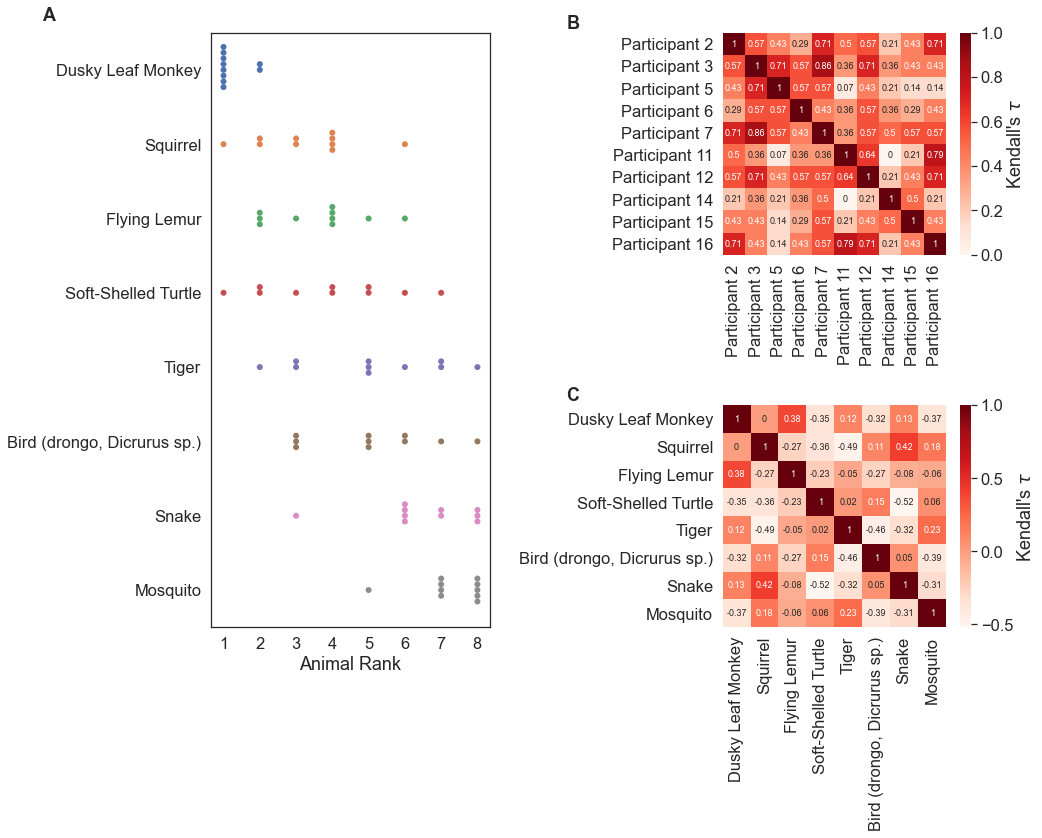

In [53]:
sns.set_style('white')
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(2, 2)

# Raw rankings
ax = fig.add_subplot(gs[:, 0])
ax.set_xticks(range(1, 9));
sns.swarmplot(data=animal_stats, orient='h', ax=ax, s=6, alpha=1);
ax.set_xlabel('Animal Rank');
up.fig_letter(ax, 'A', x=-0.6, y=1.02)

# Correlation between participants
taus = up.compute_kendall_taus(animal_stats, animal_stats, tqdm=range)[0]
taus = taus.fillna(1).round(2)
ax = fig.add_subplot(gs[0, 1])
sns.heatmap(taus, cmap='Reds', annot=True, annot_kws={'size': 9}, cbar_kws={'label': r"Kendall's $\tau$"}, ax=ax);
up.fig_letter(ax, 'B', x=-0.7, y=1.02)

# Correlation between animals
taus = up.compute_kendall_taus(animal_stats.T, animal_stats.T, tqdm=range)[0]
taus = taus.fillna(1).round(2)
ax = fig.add_subplot(gs[1, 1])
sns.heatmap(taus, cmap='Reds', annot=True, annot_kws={'size': 9}, cbar_kws={'label': r"Kendall's $\tau$"}, ax=ax);
up.fig_letter(ax, 'C', x=-0.7, y=1.02)

plt.tight_layout()
plt.savefig('Figure S6.pdf', bbox_inches="tight", format='pdf')
plt.savefig('Figure S6.png', bbox_inches="tight", dpi=600, format='png')

Figure S6. Maniq participants are capable of ranking items in an ordinal fashion. 10 Maniq participants were shown pictures of 8 animals and asked to rank them according to hedonic value (highest to lowest). (A) Each dot is the ranking given by one subject for one animal. (B) The rank correlation (Kendall's $\tau$ between participants).  (C) The rank correlation between animals.